In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
label_encoder = LabelEncoder()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Read CSV

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinML/expenses.csv')
df.head(10)

,No,Expense Name,Amount,Date,Description,Category Name
0,0,Surf Bar,10,2023-07-22T14:56:04.154,NaN,Necessities
1,1,Cinthol Soap,50,2023-07-17T19:58:48.651,NaN,Necessities
2,2,JioMart,329,2023-07-18T14:58:05.005,Soaps + toothpaste,Necessities
3,3,Abhay BDay Cake,41,2023-07-24T20:15:09.570,NaN,Default
4,4,Notebooks,220,2023-07-26T21:13:18.446,6pc,Necessities
5,5,Rolls,110,2023-07-26T21:13:44.882,NaN,Food
6,6,Hide n Seek,10,2023-07-27T17:21:52.462,NaN,Snacks
7,7,Agarbatti,15,2023-07-30T20:53:43.963,NaN,Necessities
8,8,Biscuit,10,2023-07-31T16:56:44.536,NaN,Snacks
9,9,Water bottle,20,2023-08-02T07:15:54.324,NaN,Food


Add Category Id

In [ ]:
df.drop("No",axis=1,inplace=True)
df.drop("Description",axis=1,inplace=True)
df.head()

,Expense Name,Amount,Date,Category Name
0,Surf Bar,10,2023-07-22T14:56:04.154,Necessities
1,Cinthol Soap,50,2023-07-17T19:58:48.651,Necessities
2,JioMart,329,2023-07-18T14:58:05.005,Necessities
3,Abhay BDay Cake,41,2023-07-24T20:15:09.570,Default
4,Notebooks,220,2023-07-26T21:13:18.446,Necessities


In [ ]:
df.rename(columns = {'Expense Name':'Name'}, inplace = True)
df.rename(columns = {'Category Name':'Category'}, inplace = True)

In [ ]:
df['category_id'] = label_encoder.fit_transform(df['Category'])
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head()

,Name,Amount,Date,Category,category_id
0,Surf Bar,10,2023-07-22T14:56:04.154,Necessities,2
1,Cinthol Soap,50,2023-07-17T19:58:48.651,Necessities,2
2,JioMart,329,2023-07-18T14:58:05.005,Necessities,2
3,Abhay BDay Cake,41,2023-07-24T20:15:09.570,Default,0
4,Notebooks,220,2023-07-26T21:13:18.446,Necessities,2


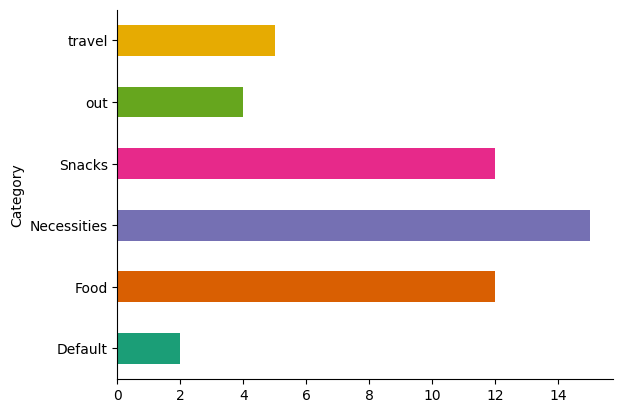

In [ ]:
df.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df['Category']).toarray()
labels = df.category_id
features.shape

(50, 4)

In [ ]:
N = 2  # Number of top correlated features to display
category_to_id = {cat: idx for idx, cat in enumerate(df['Category'].unique())}

# Find the most correlated unigrams and bigrams for each category
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Default':
  . Most correlated unigrams:
. necessities
. food
  . Most correlated bigrams:
. 
# 'Food':
  . Most correlated unigrams:
. snacks
. necessities
  . Most correlated bigrams:
. 
# 'Necessities':
  . Most correlated unigrams:
. snacks
. necessities
  . Most correlated bigrams:
. 
# 'Snacks':
  . Most correlated unigrams:
. necessities
. snacks
  . Most correlated bigrams:
. 
# 'out':
  . Most correlated unigrams:
. necessities
. travel
  . Most correlated bigrams:
. 
# 'travel':
  . Most correlated unigrams:
. snacks
. necessities
  . Most correlated bigrams:
. 


In [ ]:
X = df['Name']
y = df['Category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LogisticRegression().fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
<ipython-input-28-b591c493271e>:18: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='model_name', y='accuracy', data=cv_df,


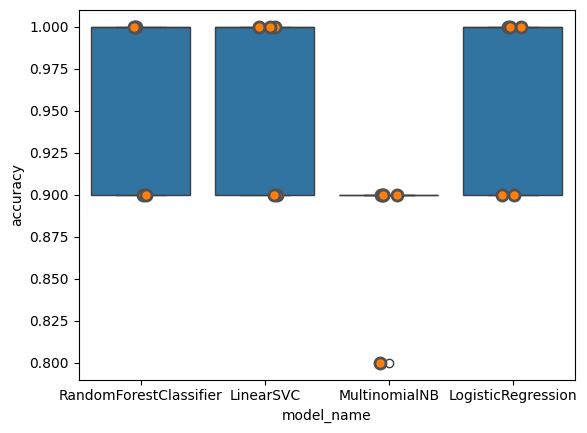

In [ ]:
models = [
    RandomForestClassifier(n_estimators=600, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.96
LogisticRegression        0.96
MultinomialNB             0.88
RandomForestClassifier    0.96
Name: accuracy, dtype: float64

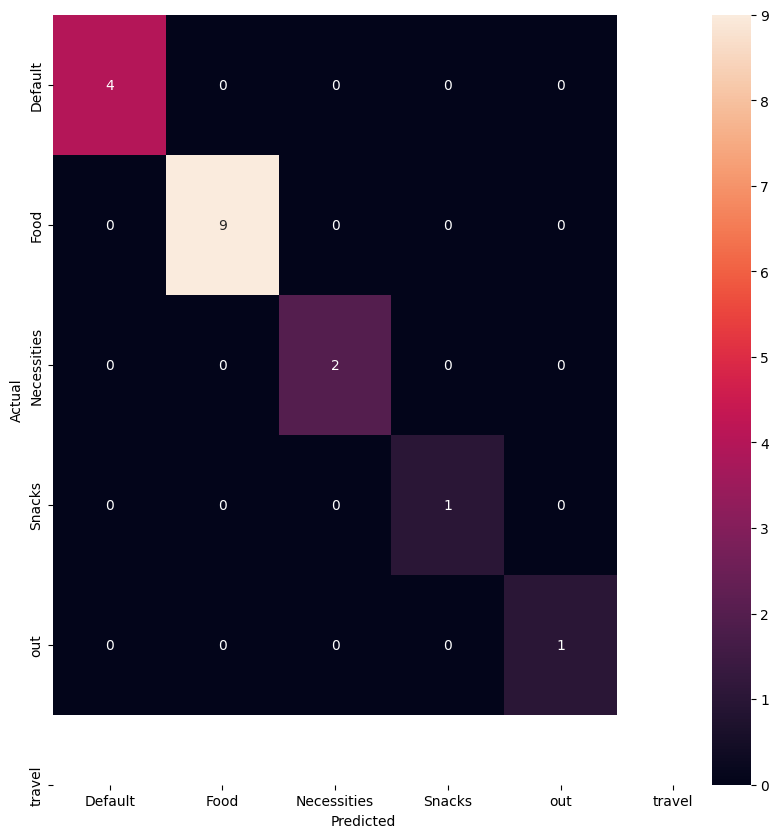

In [ ]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[id_to_category[i] for i in range(len(id_to_category))],
            yticklabels=[id_to_category[i] for i in range(len(id_to_category))])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
// predict the expense of next month using available data
